/home/anand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


{(0, 1): Text(0.24999996274709668, 0.43301271829021687, '6.0'),
 (0, 2): Text(0.2500000372529033, -0.43301270835610933, '7.0'),
 (1, 2): Text(-0.5, -9.934107536579972e-09, '8.0')}

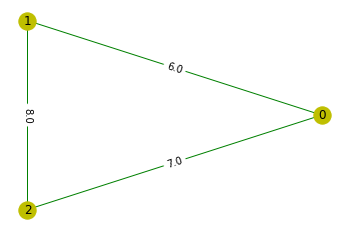

In [10]:
from scipy import optimize as opt
from scipy.optimize import Bounds

# Create a graph for the problem its is also adviseable to instantiate the weight of the graphs else it 
# be defaulted to 1
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter

n     = 3
V     = np.arange(0,n,1)
E     =[(0,1,6.0),(2,0,7.0),(1,2,8.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
fig = plt.figure()
ax1 = plt.subplot2grid((1, 1), (0, 0))
labels = nx.get_edge_attributes(G,'weight')

nx.draw(G,with_labels=True, pos=nx.circular_layout(G), node_color='y', edge_color='g')
nx.draw_networkx_edge_labels(G,nx.circular_layout(G),edge_labels=labels)

In [2]:
import os 
os.path.sys.path.append('../hamiltonian_engine/')
from hamiltonian import phase_hamiltonian as phs_ham
from hamiltonian import mixer_hamiltonian as mx_ham
from expectation_value import expectation_value as ex_vle

obj = 'x_u & ~x_v | ~x_u & x_v'
variables = ['x_u', 'x_v']

c_Hamiltonian = phs_ham(obj, variables)
m_Hamiltonian = mx_ham(c_Hamiltonian)

# Instantiate object for expectation value
expt = ex_vle(obj,variables,is_graph=True)

c_Hamiltonian.get_objFun()

(x_u & ~x_v) | (x_v & ~x_u)

In [3]:
c_Hamiltonian.Hamify(boolean=True)
c_Hamiltonian.get_pHamil()

-0.5*Z_0*Z_1

In [4]:
import numpy as np
from qiskit import *
#Gammas
gammas=[np.pi, 2*np.pi]
#Betas
betas =[np.pi/2, np.pi]

hyperparams = gammas + betas

def MAX_CUT_QAOA(hyperparams:list):
    l = len(hyperparams)
    p = 2
    gammas = hyperparams[:l//2]
    betas  = hyperparams[l//2:]
    
    for i in range(p):
        if i == 0:
            cir = c_Hamiltonian.perEdgeMap([gammas[0]],1,G,initial_Hadamard=True,barrier=True) + m_Hamiltonian.generalXMixer([betas[0]],1,measure=False,graph_map=True,graph=G)
        if i == p - 1:
            cir += c_Hamiltonian.perEdgeMap([gammas[i]],1,G,initial_Hadamard=False,barrier=True) + m_Hamiltonian.generalXMixer([betas[i]],1,measure=True,graph_map=True,graph=G)
    
        cir += c_Hamiltonian.perEdgeMap([gammas[i]],1,G,initial_Hadamard=False,barrier=True) + m_Hamiltonian.generalXMixer([betas[i]],1,measure=False,graph_map=True,graph=G)
    
    # run on local simulator
    backend      = Aer.get_backend("qasm_simulator")
    shots        = 1024

    simulate     = execute(cir, backend=backend, shots=shots)
    res = simulate.result()
    
    res = expt.get_expectationValue(res, shots, G)
    
    return -1 * res

In [5]:
from scipy import optimize as opt
from scipy.optimize import Bounds

#define the bounds for the hyperparameters
bounds = [[0, 2*np.pi], [0, np.pi]]
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq','fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq','fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
        
res = opt.minimize(MAX_CUT_QAOA, hyperparams,constraints=cons,options={"maxiter": 500} ,tol= 1e-3, method='Cobyla')

print(res)

     fun: -13.91015625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 46
  status: 1
 success: True
       x: array([4.01336581, 3.14159265, 1.64589616, 3.28206952])


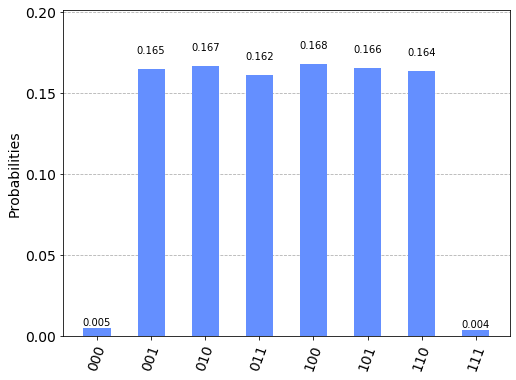

In [6]:
from qiskit.visualization import plot_histogram

hyperparams = list(res.x)
l = len(hyperparams)
gammas = hyperparams[:l//2]
betas  = hyperparams[l//2:]
p = 2
for i in range(p):
        if i == 0:
            cir = c_Hamiltonian.perEdgeMap([gammas[0]],1,G,initial_Hadamard=True,barrier=True) + m_Hamiltonian.generalXMixer([betas[0]],1,measure=False,graph_map=True,graph=G)
        if i == p - 1:
            cir += c_Hamiltonian.perEdgeMap([gammas[i]],1,G,initial_Hadamard=False,barrier=True) + m_Hamiltonian.generalXMixer([betas[i]],1,measure=True,graph_map=True,graph=G)
    
        cir += c_Hamiltonian.perEdgeMap([gammas[i]],1,G,initial_Hadamard=False,barrier=True) + m_Hamiltonian.generalXMixer([betas[i]],1,measure=False,graph_map=True,graph=G)
    
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(cir, backend=backend, shots=shots)
res = simulate.result()

# Evaluate the data from the simulator
counts = res.get_counts()
plot_histogram(counts,figsize = (8,6),bar_labels = True)

In [7]:
#Gammas
gammas=[np.pi, 2*np.pi]
#Betas
betas =[np.pi/2, np.pi]

hyperparams = gammas + betas

def MAX_CUT_QAOA(hyperparams:list):
    l = len(hyperparams)
    p = 2
    gammas = hyperparams[:l//2]
    betas  = hyperparams[l//2:]
    
    cir = c_Hamiltonian.perEdgeMap(gammas,p,G,initial_Hadamard=True,barrier=True) + m_Hamiltonian.generalXMixer(betas,p,measure=True,graph_map=True,graph=G)
    # run on local simulator
    backend      = Aer.get_backend("qasm_simulator")
    shots        = 1024

    simulate     = execute(cir, backend=backend, shots=shots)
    res = simulate.result()
    
    res = expt.get_expectationValue(res, shots, G)
    
    return -1 * res

In [8]:
from scipy import optimize as opt
from scipy.optimize import Bounds

#define the bounds for the hyperparameters
bounds = [[0, 2*np.pi], [0, np.pi]]
cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq','fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq','fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
        
res = opt.minimize(MAX_CUT_QAOA, hyperparams,constraints=cons,options={"maxiter": 500} ,tol= 1e-3, method='Cobyla')

print(res)

     fun: -14.0517578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 57
  status: 1
 success: True
       x: array([3.83927736, 3.04226172, 2.25704622, 3.4074501 ])


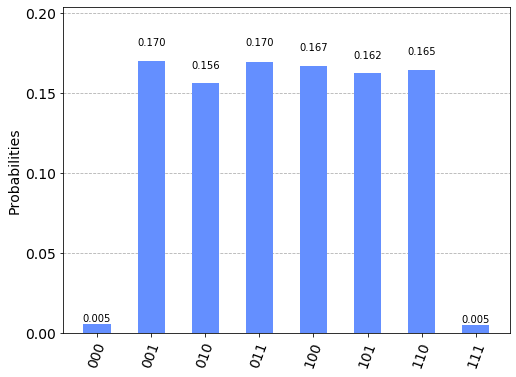

In [9]:
from qiskit.visualization import plot_histogram

hyperparams = list(res.x)
l = len(hyperparams)
gammas = hyperparams[:l//2]
betas  = hyperparams[l//2:]
p = 2
fcir = c_Hamiltonian.perEdgeMap(gammas,p,G,initial_Hadamard=True,barrier=True) + m_Hamiltonian.generalXMixer(betas,p,measure=True,graph_map=True,graph=G)
    
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(cir, backend=backend, shots=shots)
res = simulate.result()

# Evaluate the data from the simulator
counts = res.get_counts()
plot_histogram(counts,figsize = (8,6),bar_labels = True)